In [ ]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

import pandas as pd

In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Developing a simple matrix factorization with pytorch


We'll start developing a matrix factorization model which focused on regressions tasks using pytorch for modelling and MSE for loss.

In [1]:
from simple_mf import MF, MFDataLoader

In [ ]:

def train(dataloader, model, loss_fn, optimizer, n_epochs=10):
    batch_losses = [] 
    epoch_losses = []
    model.train()
    for epoch in range(n_epochs):

        epoch_loss = []
        for batch, ((user_ids, item_ids), ratings) in enumerate(dataloader):
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.to(device).float()

            pred = model(user_ids, item_ids)
            loss = loss_fn(pred, ratings)

            epoch_loss.append(loss.item())
            batch_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        epoch_losses.append(epoch_loss)
        print(f"epoch mean loss: {epoch_loss:>7f}; Epoch: {epoch+1}/{n_epochs}")
    return batch_losses, epoch_losses
        


In [90]:
data = MFDataLoader('movielens_1m_ratings.csv')
dataloader = DataLoader(data, batch_size=256, shuffle=True)

In [100]:
model = MF(num_users=data.n_users, num_items=data.n_items, factors=30).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [101]:
b_loss, e_loss = train(dataloader, model, loss_fn, optimizer)

epoch mean loss: 3.352641; Epoch: 1/10
epoch mean loss: 1.405438; Epoch: 2/10
epoch mean loss: 1.024184; Epoch: 3/10
epoch mean loss: 0.905355; Epoch: 4/10
epoch mean loss: 0.853854; Epoch: 5/10
epoch mean loss: 0.824327; Epoch: 6/10
epoch mean loss: 0.804313; Epoch: 7/10
epoch mean loss: 0.792881; Epoch: 8/10
epoch mean loss: 0.781831; Epoch: 9/10
epoch mean loss: 0.775829; Epoch: 10/10


In [104]:
import matplotlib.pyplot as plt

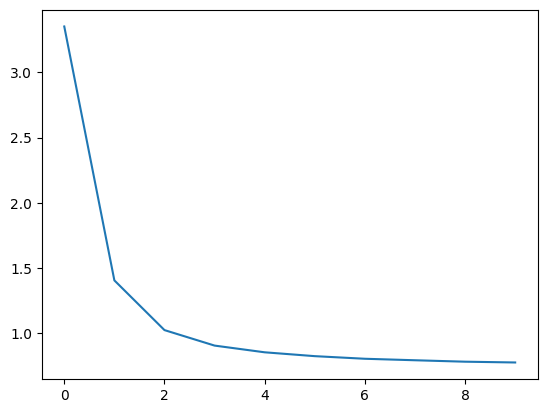

In [107]:
plt.plot(e_loss, label='epoch loss')

## Developing a MF model based using BPR opt


Now we'll generalize the previous implementation using implicit feedback data and applying BPR (Bayesian personalized ranking) loss function, so that the model is capable of building personalzied rankings for users

### Step 1 : adapt training data for BPR


BPR expects implicit feedback data and relative ordering in the training dataset

In [4]:
from utils import generate_bpr_dataset

In [5]:
interactions = pd.read_csv('movielens_1m_ratings.csv')[["user", "item"]]

In [6]:
zero_based_indexing = {v: K for K, v in enumerate(interactions["item"].unique())}

In [7]:
interactions["item"] = interactions["item"].map(zero_based_indexing)

In [8]:
bpr_df = generate_bpr_dataset(interactions)

In [9]:
bpr_df["user"].values

array([   1,    1,    1, ..., 6040, 6040, 6040], shape=(3000627,))

### Step 2: Create a MF model using BPR loss function

In [33]:
from bpr_mf import bprMF, bprMFDataloader, bpr_loss_with_reg, bpr_train

In [13]:
bpr_df

,user,pos_item,neg_item
0,1,0,1858
1,1,0,1880
2,1,0,1601
3,1,1,2391
4,1,1,1295
...,...,...,...
3000622,6040,152,1110
3000623,6040,152,2149
3000624,6040,26,2730
3000625,6040,26,685


In [22]:
data_bpr = bprMFDataloader(bpr_df)
dataloader_bpr = DataLoader(data_bpr, batch_size=256, shuffle=True)

In [23]:

n_users = bpr_df.user.max() + 1
n_items = bpr_df.pos_item.max() + 1

In [17]:
n_users, n_items

(np.int64(6041), np.int64(3706))

In [29]:
model = bprMF(num_users=n_users, num_items=n_items, factors=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [30]:
bpr_train(dataloader_bpr, model, bpr_loss_with_reg, optimizer)

epoch mean loss: 0.272368; Epoch: 1/10
epoch mean loss: 0.226940; Epoch: 2/10
epoch mean loss: 0.221201; Epoch: 3/10
epoch mean loss: 0.218657; Epoch: 4/10
epoch mean loss: 0.217739; Epoch: 5/10
epoch mean loss: 0.217188; Epoch: 6/10
epoch mean loss: 0.217079; Epoch: 7/10
epoch mean loss: 0.216474; Epoch: 8/10
epoch mean loss: 0.216440; Epoch: 9/10
epoch mean loss: 0.216436; Epoch: 10/10


([0.6931585073471069,
  0.6931355595588684,
  0.6931662559509277,
  0.693078875541687,
  0.6931785345077515,
  0.6932651996612549,
  0.6930447816848755,
  0.693041205406189,
  0.6930350661277771,
  0.6931625604629517,
  0.6935032606124878,
  0.6936453580856323,
  0.6934383511543274,
  0.6933249831199646,
  0.6934181451797485,
  0.6930136680603027,
  0.6935532093048096,
  0.6928197741508484,
  0.6936277747154236,
  0.6939733028411865,
  0.693371593952179,
  0.6925952434539795,
  0.6934641003608704,
  0.6930648684501648,
  0.6929869055747986,
  0.6931827068328857,
  0.6930952668190002,
  0.6927254796028137,
  0.6936200261116028,
  0.6930072903633118,
  0.6934229135513306,
  0.6933799982070923,
  0.6930944919586182,
  0.6936265826225281,
  0.6929293870925903,
  0.6928893327713013,
  0.6917294859886169,
  0.6939678192138672,
  0.6927934885025024,
  0.6920948624610901,
  0.6945817470550537,
  0.6943401098251343,
  0.6915888786315918,
  0.6922501921653748,
  0.6933974623680115,
  0.695021033